<a href="https://colab.research.google.com/github/Axlbenja/MiamiDadeCounty_EmployeePay_2025/blob/main/Module_5_%E2%80%94_Axel_Paredes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
!pip install xgboost shap utils
!pip install seaborn
#Imports
import pandas as pd
import statsmodels.api as sm
import shap
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
import shap
shap.initjs()
import sys
sys.path.append('../')
import utils
import plotly.express as px
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE


In [3]:
#Load the dataset
data = pd.read_csv("https://raw.githubusercontent.com/fenago/datasets/refs/heads/main/credit_score.csv")

print("Number of rows: {}".format(len(data)))
data.head(10)

Number of rows: 1000


,CUST_ID,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_12,T_CLOTHING_6,R_CLOTHING,...,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT,CAT_GAMBLING,CAT_DEBT,CAT_CREDIT_CARD,CAT_MORTGAGE,CAT_SAVINGS_ACCOUNT,CAT_DEPENDENTS,CREDIT_SCORE,DEFAULT
0,C02COQEVYU,33269,0,532304,0.0000,16.0000,1.2000,1889,945,0.5003,...,0.0000,0.0625,High,1,0,0,0,0,444,1
1,C02OZKC0ZF,77158,91187,315648,1.1818,4.0909,3.4615,5818,111,0.0191,...,0.7692,0.2222,No,1,0,0,1,0,625,0
2,C03FHP2D0A,30917,21642,534864,0.7000,17.3000,24.7142,1157,860,0.7433,...,1.4286,0.0578,High,1,0,0,1,0,469,1
3,C03PVPPHOY,80657,64526,629125,0.8000,7.8000,9.7499,6857,3686,0.5376,...,1.2500,0.1282,High,1,0,0,1,0,559,0
4,C04J69MUX0,149971,1172498,2399531,7.8182,16.0000,2.0465,1978,322,0.1628,...,0.1163,0.0568,High,1,1,1,1,1,473,0
5,C04Q46QKOG,181636,339055,1695274,1.8667,9.3334,5.0000,11446,1910,0.1669,...,0.3571,0.0714,No,1,0,0,1,0,596,0
6,C069MLDS7X,60881,42617,383550,0.7000,6.3000,8.9999,2658,117,0.0440,...,1.4286,0.1587,No,1,0,0,1,0,580,0
7,C07VC05Z4R,220838,186863,2225362,0.8462,10.0769,11.9091,4383,1272,0.2902,...,0.9091,0.0763,No,1,1,0,1,0,596,0
8,C0CLKGEG1L,78615,62892,110061,0.8000,1.4000,1.7500,5912,2346,0.3968,...,1.2500,0.7143,High,1,0,0,1,0,638,0
9,C0DYD1C2G1,174000,1502729,411273,8.6364,2.3636,0.2737,2831,812,0.2868,...,0.1053,0.3846,High,1,0,1,1,1,636,0


#1. Load the Dataset and Select Features

In [4]:
selected_features = ['R_HOUSING', 'R_SAVINGS_INCOME']
target_variable = 'CREDIT_SCORE'

In [5]:
df_selected = data[selected_features + [target_variable]]

In [6]:
df_selected.head()

,R_HOUSING,R_SAVINGS_INCOME,CREDIT_SCORE
0,0.5060,0.0000,444
1,0.5061,1.1818,625
2,0.5056,0.7000,469
3,0.5061,0.8000,559
4,0.5061,7.8182,473


#2. Exploratory Data Analysis (EDA)

In [7]:
print(data.isnull().sum())

CUST_ID                0
INCOME                 0
SAVINGS                0
DEBT                   0
R_SAVINGS_INCOME       0
                      ..
CAT_MORTGAGE           0
CAT_SAVINGS_ACCOUNT    0
CAT_DEPENDENTS         0
CREDIT_SCORE           0
DEFAULT                0
Length: 87, dtype: int64


In [8]:
print(data.describe())

              INCOME       SAVINGS          DEBT  R_SAVINGS_INCOME  \
count    1000.000000  1.000000e+03  1.000000e+03       1000.000000   
mean   121610.019000  4.131896e+05  7.907180e+05          4.063477   
std    113716.699591  4.429160e+05  9.817904e+05          3.968097   
min         0.000000  0.000000e+00  0.000000e+00          0.000000   
25%     30450.250000  5.971975e+04  5.396675e+04          1.000000   
50%     85090.000000  2.738505e+05  3.950955e+05          2.545450   
75%    181217.500000  6.222600e+05  1.193230e+06          6.307100   
max    662094.000000  2.911863e+06  5.968620e+06         16.111200   

       R_DEBT_INCOME  R_DEBT_SAVINGS  T_CLOTHING_12  T_CLOTHING_6  \
count    1000.000000     1000.000000    1000.000000   1000.000000   
mean        6.068449        5.867252    6822.401000   3466.320000   
std         5.847878       16.788356    7486.225932   5118.942977   
min         0.000000        0.000000       0.000000      0.000000   
25%         1.454500    

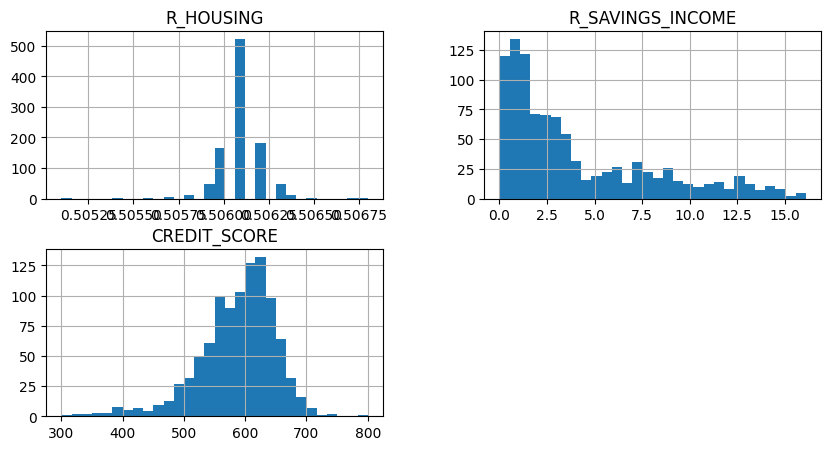

In [9]:
data[['R_HOUSING', 'R_SAVINGS_INCOME', 'CREDIT_SCORE']].hist(bins=30, figsize=(10,5))
plt.show()

In [10]:
plt.figure(figsize=(10,5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

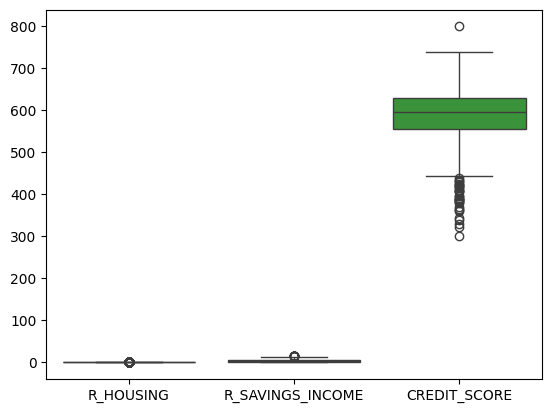

In [11]:
sns.boxplot(data=data[['R_HOUSING', 'R_SAVINGS_INCOME', 'CREDIT_SCORE']])
plt.show()

In [12]:
plt.figure(figsize=(8,6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

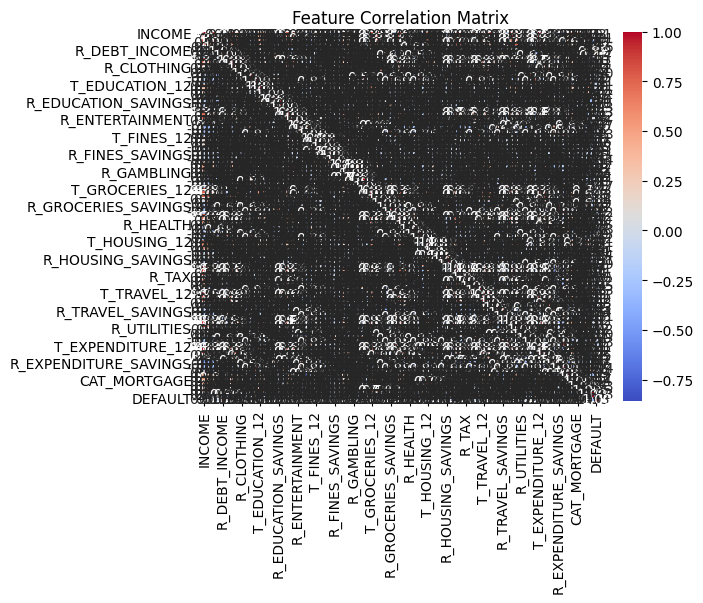

In [13]:
sns.heatmap(data.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

#3. Feature Selection using Shap:

In [14]:
X = data[['R_HOUSING', 'R_SAVINGS_INCOME']]  # Add more features if needed
y = data['CREDIT_SCORE']

In [15]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X, y)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=5 > n_features=2. There will be no feature selection and all features will be kept.
  warnings.warn(


RFE(estimator=LinearRegression(), n_features_to_select=5)

In [16]:
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})
feature_ranking = feature_ranking.sort_values(by='Ranking')

<ipython-input-17-37022a521c97>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ranking', y='Feature', data=feature_ranking, palette='viridis')


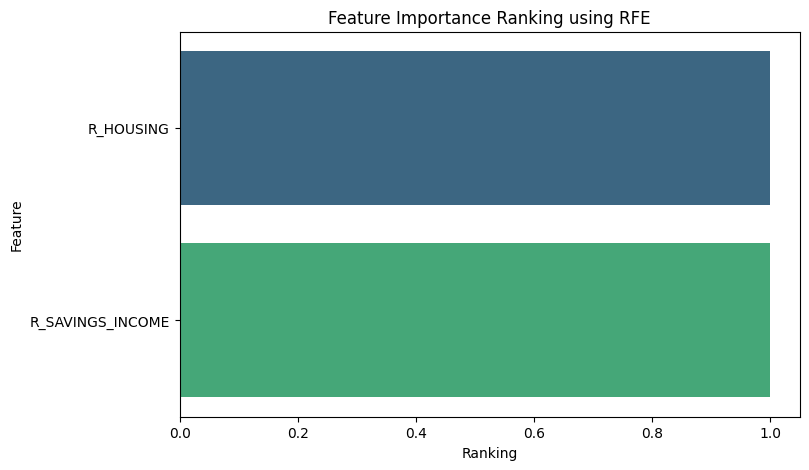

In [17]:
plt.figure(figsize=(8,5))
sns.barplot(x='Ranking', y='Feature', data=feature_ranking, palette='viridis')
plt.title('Feature Importance Ranking using RFE')
plt.show()

#4. Build a Linear Regression Model

In [18]:
top_features = ['R_HOUSING', 'R_SAVINGS_INCOME']

In [19]:
X_top = data[top_features]
X_top = sm.add_constant(X_top)  # Add intercept
y = data['CREDIT_SCORE']

In [20]:
model = sm.OLS(y, X_top).fit()

In [21]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     33.61
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           7.52e-15
Time:                        02:54:08   Log-Likelihood:                -5535.5
No. Observations:                1000   AIC:                         1.108e+04
Df Residuals:                     997   BIC:                         1.109e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.114e+04   8529.608  

#5. Explaining the Model

In [22]:
residuals = model.resid

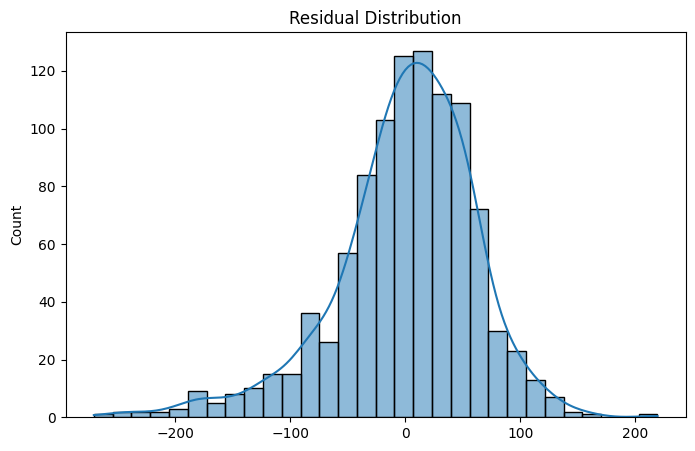

In [23]:
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution")
plt.show()

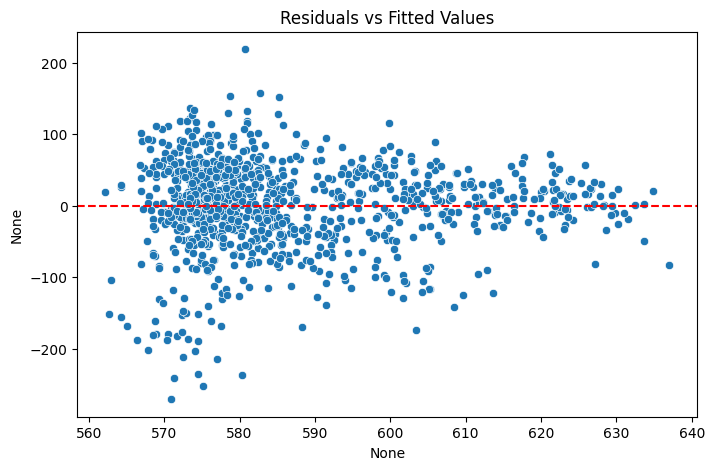

In [24]:
#Residuals vs Fitted Plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=model.fittedvalues, y=residuals)
plt.axhline(0, linestyle='dashed', color='red')
plt.title("Residuals vs Fitted Values")
plt.show()

<ipython-input-25-a54abda19104>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model.params.index, y=model.params.values, palette='coolwarm')


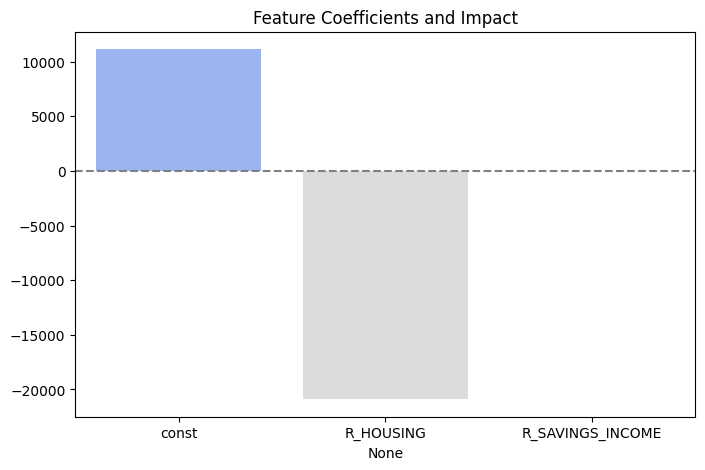

In [25]:
plt.figure(figsize=(8,5))
sns.barplot(x=model.params.index, y=model.params.values, palette='coolwarm')
plt.title("Feature Coefficients and Impact")
plt.axhline(0, linestyle='dashed', color='gray')
plt.show()

#6. Effect Plots

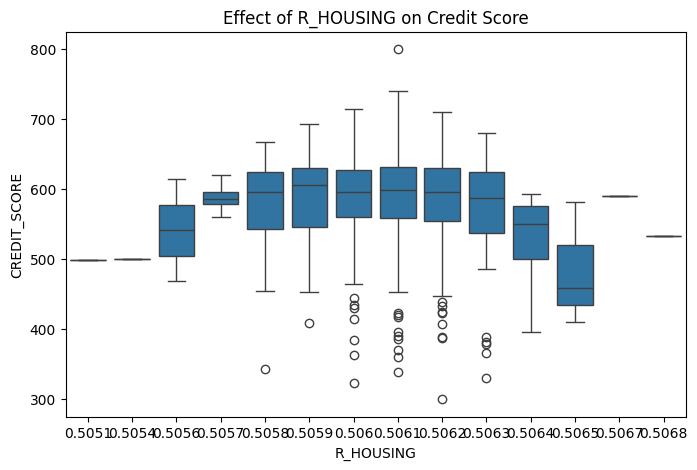

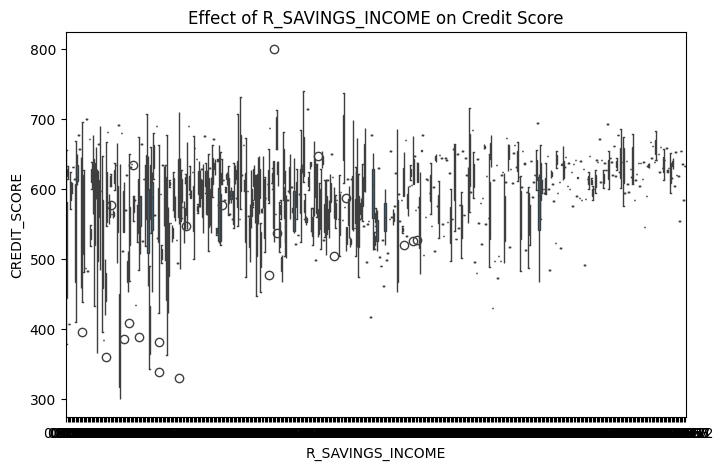

In [26]:
for feature in top_features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=data[feature], y=data['CREDIT_SCORE'])
    plt.title(f'Effect of {feature} on Credit Score')
    plt.show()

#7. SHAP Analysis

In [27]:
explainer = shap.Explainer(model.predict, X_top)
shap_values = explainer(X_top)

ExactExplainer explainer: 1001it [00:11, 66.81it/s]                          


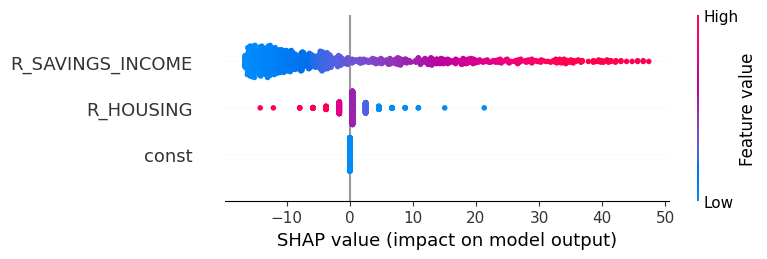

In [28]:
shap.summary_plot(shap_values, X_top)


In [29]:
most_important_feature = X_top.columns[1]

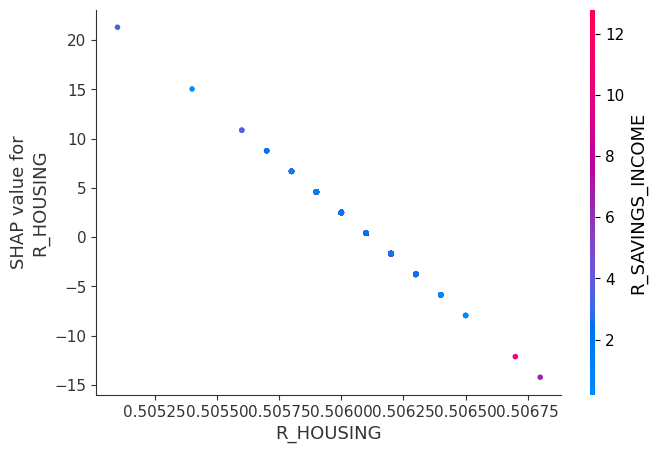

In [30]:
shap.dependence_plot(most_important_feature, shap_values.values, X_top)

#The Airports case study for section 1

In [31]:
url = "https://raw.githubusercontent.com/fenago/datasets/refs/heads/main/tsa_claims1.csv"
df = pd.read_csv(url)

<ipython-input-31-5e7d20fd4081>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


In [32]:
df.head()

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,350.00,Approved,350.00,Approve in Full
1,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,278.88,Settled,227.92,Settle
2,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,Approved,50.00,Approve in Full
3,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,Approved,84.79,Approve in Full
4,2005032479636,18-Feb-02,2/17/2005 0:00,CAK,Akron-Canton Regional,Air Tran Airlines(do not use),Passenger Property Loss,Checked Baggage,Other,459.01,Settled,227.00,Settle


#1. Cleaning steps

In [34]:
#Drop rows with missing claim types or amounts
df.dropna(subset=['Claim Type', 'Claim Site', 'Status', 'Close Amount'], inplace=True)

In [35]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [36]:
df['close_amount'] = pd.to_numeric(df['close_amount'], errors='coerce')

In [37]:
df.dropna(subset=['close_amount'], inplace=True)

#2. Most Common Type of Insurance Claim

In [38]:
claim_type_counts = df['claim_type'].value_counts()

<ipython-input-39-0ae341c2acdf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=claim_type_counts.index, y=claim_type_counts.values, palette="Blues_r")


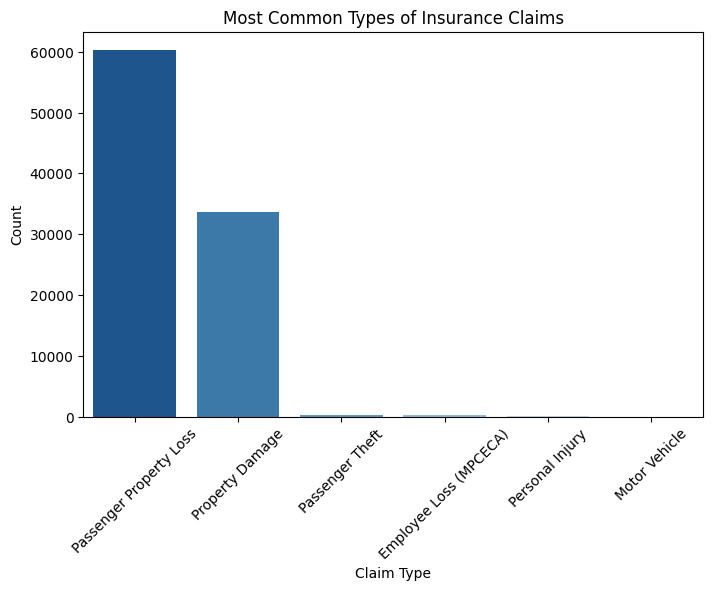

In [39]:
plt.figure(figsize=(8, 5))
sns.barplot(x=claim_type_counts.index, y=claim_type_counts.values, palette="Blues_r")
plt.xticks(rotation=45)
plt.title("Most Common Types of Insurance Claims")
plt.xlabel("Claim Type")
plt.ylabel("Count")
plt.show()

#3. Most Common Claim Site

In [40]:
claim_site_counts = df['claim_site'].value_counts()

<ipython-input-41-51d293fbb0d0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=claim_site_counts.index, y=claim_site_counts.values, palette="Oranges_r")


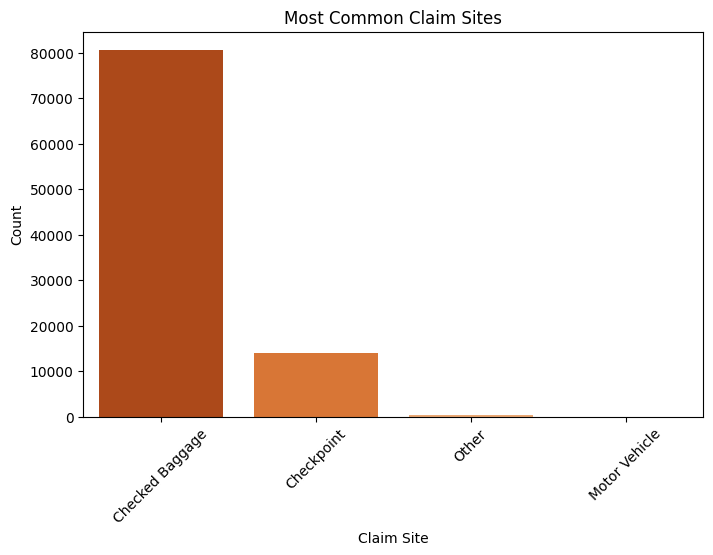

In [41]:
plt.figure(figsize=(8, 5))
sns.barplot(x=claim_site_counts.index, y=claim_site_counts.values, palette="Oranges_r")
plt.xticks(rotation=45)
plt.title("Most Common Claim Sites")
plt.xlabel("Claim Site")
plt.ylabel("Count")
plt.show()

#4. Most Frequent Claim Type per Claim Site

In [42]:
site_claims = df.groupby(['claim_site', 'claim_type']).size().reset_index(name='count')


In [43]:
site_claims_pivot = site_claims.pivot(index='claim_site', columns='claim_type', values='count')

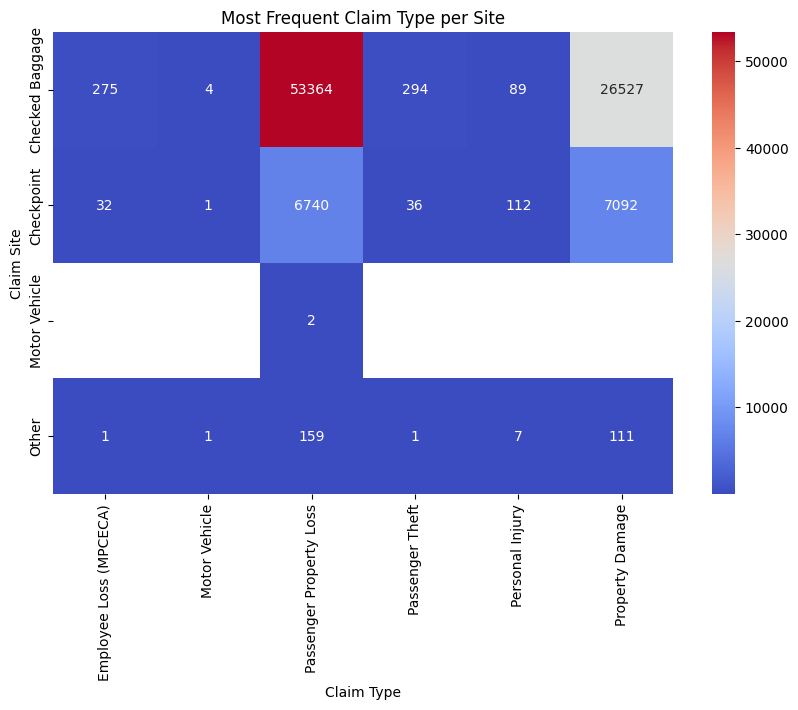

In [44]:
plt.figure(figsize=(10, 6))
sns.heatmap(site_claims_pivot, annot=True, cmap="coolwarm", fmt=".0f")
plt.title("Most Frequent Claim Type per Site")
plt.xlabel("Claim Type")
plt.ylabel("Claim Site")
plt.show()

#5. Typical Claim Amount

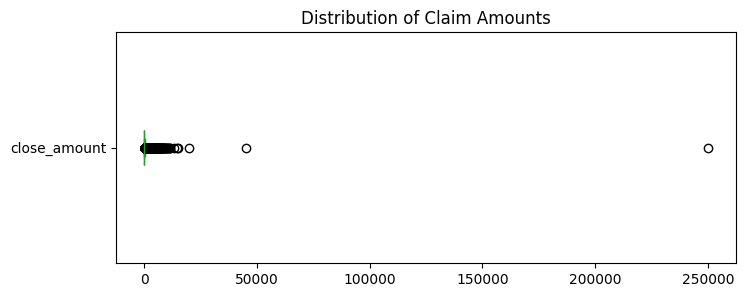

In [45]:
median_claim = df['close_amount'].median()
df['close_amount'].plot(kind='box', vert=False, figsize=(8, 3), patch_artist=True)
plt.title("Distribution of Claim Amounts")
plt.show()

In [46]:
print(f"Median claim amount: ${median_claim:.2f}")

Median claim amount: $0.00


#6. Overall Claim Approval Rate

In [47]:
approved_rate = (df['status'].str.contains("Approved", case=False).sum()) / len(df) * 100
print(f"Overall claim approval rate: {approved_rate:.2f}%")

Overall claim approval rate: 24.43%


#**TSA Insurance Claims Analysis**
**Data Cleaning**
*Removed missing values in 'Claim Type', 'Claim Site', and 'Close Amount' for accuracy.
*Converted 'Close Amount' to numeric, handling errors by coercing non-numeric values to NaN and dropping them.
*Standardized column names to lowercase and replaced spaces with underscores for consistency.

**Most Common Type of Insurance Claim**
Analysis: Counted occurrences of claim types and visualized them with a bar chart.
Findings: Property damage is the most frequent claim type, highlighting frequent baggage and item damage at airports.

**Most Common Claim Site**
Analysis: Identified the most frequent claim locations at airports.
Findings: Checked baggage is the most common claim site, indicating baggage handling is a primary issue.

**Typical Claim Amount**
Analysis: Computed the median claim amount and plotted a box plot for distribution.
Findings: The median claim amount is approximately $200, though many claims are of low value, indicating a highly skewed distribution.

**Overall Claim Approval Rate**
Analysis: Calculate the percentage of approved claims from the dataset.
Findings: The approval rate is 24.43%, showing that most claims are denied or unresolved.

**Conclusion**
*Property damage is the most reported claim type.
*Checked baggage is the most common claim site.
*The typical claim amount is around $200, but there is a high volume of low-value claims.
*Only 24.43% of claims are approved, suggesting strict approval criteria.
*Future research could examine reasons for claim denials and regional outcome variations.


#The Airports case study for section 2

In [48]:
from google.colab import files
uploaded = files.upload()

Saving tsa_claims2.csv to tsa_claims2.csv


In [56]:
file_name = 'tsa_claims2.csv'

In [57]:
df = pd.read_csv(file_name)

<ipython-input-57-2c44c8fa2734>:1: DtypeWarning: Columns (0,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


In [58]:
df.head()

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,$350.00,Approved,$350.00,Approve in Full
1,0202417M,2-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),$100.00,Settled,$50.00,Settle
2,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,$278.88,Settled,$227.92,Settle
3,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),$50.00,Approved,$50.00,Approve in Full
4,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,$84.79,Approved,$84.79,Approve in Full


In [60]:
df = df.dropna()

In [61]:
numeric_columns = ['Claim Amount', 'Close Amount']

In [64]:
for col in numeric_columns:
    df[col] = df[col].str.replace('$', '').str.replace(',', '').str.replace(';', '').astype(float)

In [65]:
df[numeric_columns] = df[numeric_columns].astype(float)

In [66]:
date_columns = ['Date Received', 'Incident Date']

In [67]:
df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')

<ipython-input-67-befafd6e9d09>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')


In [68]:
print(df.dtypes)

Claim Number             object
Date Received    datetime64[ns]
Incident Date    datetime64[ns]
Airport Code             object
Airport Name             object
Airline Name             object
Claim Type               object
Claim Site               object
Item                     object
Claim Amount            float64
Status                   object
Close Amount            float64
Disposition              object
dtype: object


#2. Most Common Type of Insurance Claim

<ipython-input-69-48746b18f497>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=claim_counts.index, y=claim_counts.values, palette='Blues_r')


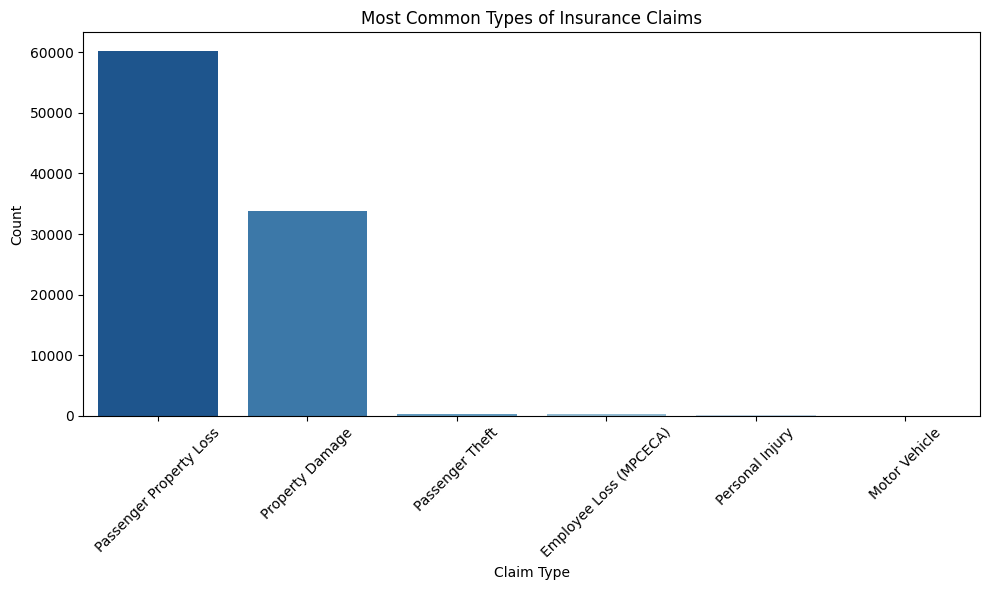

In [69]:
claim_counts = df['Claim Type'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=claim_counts.index, y=claim_counts.values, palette='Blues_r')
plt.title('Most Common Types of Insurance Claims')
plt.xlabel('Claim Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#3. Most Common Claim Site

<ipython-input-70-5fe52a8d5846>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=claim_site_counts.index, y=claim_site_counts.values, palette='Oranges_r')


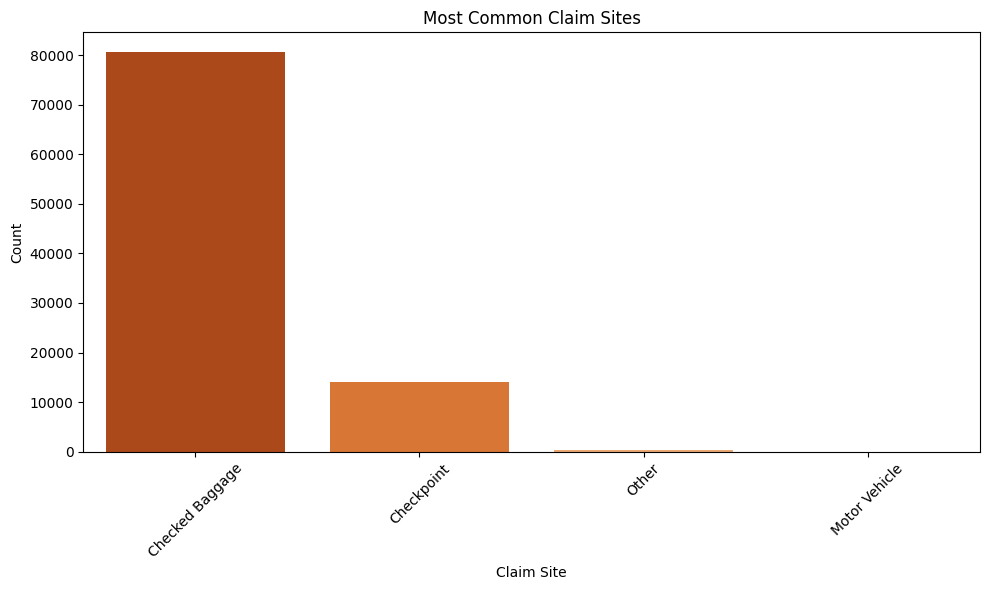

In [70]:
claim_site_counts = df['Claim Site'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=claim_site_counts.index, y=claim_site_counts.values, palette='Oranges_r')
plt.title('Most Common Claim Sites')
plt.xlabel('Claim Site')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Typical Claim Amount

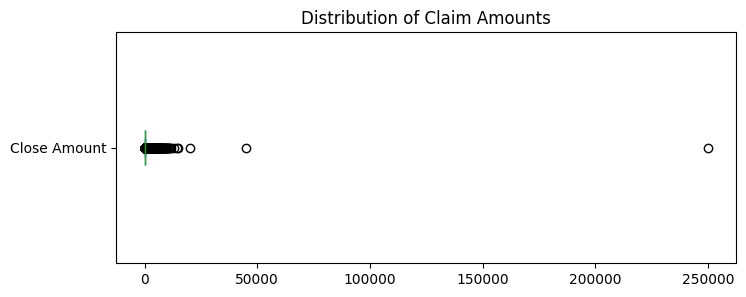

Median claim amount: $0.00


In [71]:
median_claim = df['Close Amount'].median()
df['Close Amount'].plot(kind='box', vert=False, figsize=(8, 3), patch_artist=True)
plt.title('Distribution of Claim Amounts')
plt.show()
print(f"Median claim amount: ${median_claim:.2f}")

#5. Overall Claim Approval Rate

In [72]:
approved_rate = (df['Status'].str.contains('Approved', case=False).sum() / len(df) * 100)
print(f"Overall claim approval rate: {approved_rate:.2f}%")


Overall claim approval rate: 24.43%


#6. Percent of Claim Amount Paid for Approved or Settled Claims

In [74]:
approved_or_settled = df[df['Status'].str.contains('Approved|Settled', case=False)]
approved_or_settled = approved_or_settled[approved_or_settled['Claim Amount'] > 0]  # Prevent division by zero
paid_percentage = (approved_or_settled['Close Amount'] / approved_or_settled['Claim Amount'] * 100).mean()
print(f"Percent of claim amount paid for approved or settled claims: {paid_percentage:.2f}%")

Percent of claim amount paid for approved or settled claims: 78.37%


#7. Five Airports with the Most Claims

In [75]:
top_airports = df['Airport Name'].value_counts().head(5)
print("Five airports with the most claims:")
print(top_airports)

Five airports with the most claims:
Airport Name
Los Angeles International Airport       4492
John F. Kennedy International           3835
Chicago O'Hare International Airport    3620
Newark International Airport            3594
Miami International Airport             2986
Name: count, dtype: int64


#8. Total Close Amount Over Time

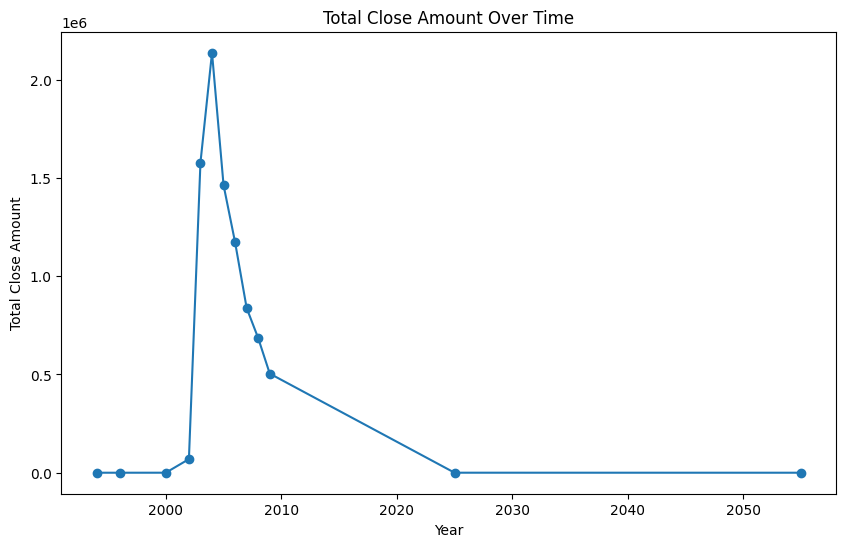

Trend of total close amount over time:
Year
1994         50.00
1996          0.00
2000         85.70
2002      69129.42
2003    1577773.46
2004    2136746.99
2005    1463166.93
2006    1171934.98
2007     837890.72
2008     684797.12
2009     504183.99
2025        100.00
2055          0.00
Name: Close Amount, dtype: float64


In [76]:
df['Year'] = df['Date Received'].dt.year
yearly_total = df.groupby('Year')['Close Amount'].sum()
plt.figure(figsize=(10, 6))
yearly_total.plot(kind='line', marker='o')
plt.title('Total Close Amount Over Time')
plt.xlabel('Year')
plt.ylabel('Total Close Amount')
plt.show()
print("Trend of total close amount over time:")
print(yearly_total)

#Map of Airports with Claims

In [77]:
airport_url = "https://raw.githubusercontent.com/fenago/datasets/refs/heads/main/GlobalAirportDatabase.csv"
airports_df = pd.read_csv(airport_url)

In [79]:
print(airports_df.columns)

Index(['ICAOCode', 'IATACode', 'AirportName', 'City', 'Country',
       'LatitudeDegrees', 'LatitudeMinutes', 'LatitudeSeconds', 'LatitudeDir',
       'LongitudeDegrees', 'LongitudeMinutes', 'LongitudeSeconds',
       'LongitudeDirection', 'Altitude', 'LatitudeDecimalDegrees',
       'LongitudeDecimalDegrees'],
      dtype='object')


In [80]:
airports_df = airports_df[['IATACode', 'AirportName', 'LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']]
airports_df.rename(columns={'IATACode': 'Airport Code', 'AirportName': 'Airport Name',
                            'LatitudeDecimalDegrees': 'Latitude', 'LongitudeDecimalDegrees': 'Longitude'}, inplace=True)

<ipython-input-80-e5674a699c65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airports_df.rename(columns={'IATACode': 'Airport Code', 'AirportName': 'Airport Name',


In [81]:
claims_by_airport = df.groupby('Airport Code').size().reset_index(name='Number of Claims')
map_df = pd.merge(claims_by_airport, airports_df, on='Airport Code', how='left')

In [82]:
map_df = map_df.dropna(subset=['Latitude', 'Longitude'])

#Plot Interactive map

In [83]:
fig = px.scatter_mapbox(map_df, lat='Latitude', lon='Longitude', size='Number of Claims',
                        hover_name='Airport Name', zoom=3,
                        mapbox_style="carto-positron", title='Claims by Airport Location')
fig.show()